In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

# Decrease geospatial query latency from minutes to seconds using Zarr on Amazon S3

***

This notebook provides sample code to convert NetCF files to Zarr format.

## Table of contents <a class='anchor' name="top"></a>

***

- [Before you begin](#1)
- [Load libraries](#2)
- [Connect to Dask cluster](#3)
- [Scale out Dask cluster](#3a)
- [Explore MERRA-2 dataset](#3z)
- [rechunker: Batch convert NetCDF files to Zarr](#4)
  - [Open the NetCDF dataset](#4a)
  - [Query the NetCDF dataset](#4aa)
  - [Define Zarr chunking strategy](#4b)
  - [Set up Zarr store](#4c)
  - [Batch convert NetCDF to Zarr](#4d)
  - [Query the Zarr store](#4e)
- [xarray: Append NetCDF files to Zarr store](#5)
- [Scale in Dask cluster](#7)

## Before you begin <a class='anchor' name="1"></a> [<font size=1>TOC</font>](#top)


***

Before using this notebook, you will need: 

- a Dask cluster.
- a Jupyter kernel with the required libraries installed.

If you have not done so, follow the instructions in the blog post to deploy the Dask infrastructure and create the Juypter kernel.

Paste in the name of the S3 bucket that was created by the CDK deployment (it will start with "converttozarrstack"). The notebook will write the converted Zarr store to this bucket.

In [4]:
S3_BUCKET_ZARR = "pculurc-zarr"

env: AWS_PROFILE=draios-dev-developer


## Load libraries <a class='anchor' name="2"></a>[<font size=1>TOC</font>](#top)

***

In [5]:
import xarray as xr
import hvplot.xarray
import dask
from dask.distributed import Client
import zarr
import s3fs
from rechunker import rechunk

## Connect to Dask cluster <a class='anchor' name="3"></a>[<font size=1>TOC</font>](#top)

***

In [6]:
DASK_SCHEDULER_URL = "dask-scheduler:8786"

In [7]:
client = Client(DASK_SCHEDULER_URL)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+---------+-----------------+-----------------+-----------------+
| Package | Client          | Scheduler       | Workers         |
+---------+-----------------+-----------------+-----------------+
| python  | 3.10.11.final.0 | 3.10.13.final.0 | 3.10.13.final.0 |
| tornado | 6.3.2           | 6.3.3           | 6.3.3           |
+---------+-----------------+-----------------+-----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


The notebook is now a client of the Dask scheduler at the URL provided. You can retrieve more information about the scheduler by clicking on Scheduler Info in the  HTML representation below. Once Scheduler Info is opened, you can click on Workers to see the list of workers.

In [8]:
client

<Client: 'tcp://100.96.5.119:8786' processes=30 threads=240, memory=0.91 TiB>

## Scale out Dask cluster <a class='anchor' name="3a"></a>[<font size=1>TOC</font>](#top)

***

The CDK template creates a single Dask worker. The code below increases the number of Dask workers to 30. While the cell  returns immediately, wait 2-3 minutes for the process to complete. (Estimated times given in the rest of this notebook assume 30 dask workers.) 

In [10]:
NUM_DASK_WORKERS = 30

DASK_CLUSTER_NAME = "Dask-Cluster"
DASK_CLUSTER_SERVICE = "Dask-Worker"

%env AWS_PROFILE=draios-dev-developer
!aws ecs update-service --service {DASK_CLUSTER_SERVICE} --desired-count {NUM_DASK_WORKERS} --cluster {DASK_CLUSTER_NAME} 

{
    "service": {
        "serviceArn": "arn:aws:ecs:us-east-1:059797578166:service/Dask-Cluster/Dask-Worker",
        "serviceName": "Dask-Worker",
        "clusterArn": "arn:aws:ecs:us-east-1:059797578166:cluster/Dask-Cluster",
        "loadBalancers": [],
        "serviceRegistries": [
            {
                "registryArn": "arn:aws:servicediscovery:us-east-1:059797578166:service/srv-aslgr75x7qfbd3m3"
            }
        ],
        "status": "ACTIVE",
        "desiredCount": 1,
        "runningCount": 1,
        "pendingCount": 29,
        "launchType": "FARGATE",
        "platformVersion": "LATEST",
        "platformFamily": "Linux",
        "taskDefinition": "arn:aws:ecs:us-east-1:059797578166:task-definition/Dask-Worker:4",
        "deploymentConfiguration": {
            "deploymentCircuitBreaker": {
                "enable": false,
                "rollback": false
            },
            "maximumPercent": 200,
            "minimumHealthyPercent": 100
        },
   

## Explore MERRA-2 Dataset <a class='anchor' name="3z"></a>[<font size=1>TOC</font>](#top)

***

To demonstrate converting files from NetCDF to Zarr, we'll use the [NASA Prediction of Worldwide Energy Resources (NASA POWER)](https://registry.opendata.aws/nasa-power/) MERRA-2 dataset. The MERRA-2 (UTC) dataset contains hourly observations of 49 variables. 

The cell below shows the data files available in the NASA POWER dataset for January of 2021. The data is organized in subfolders labelled by year and month number, and within each month, there is one file per dataset per day. We'll use the ```merra2_utc``` files which are rougly 180 MiB each day.

In [11]:
!aws s3 ls --no-sign-request s3://power-datastore/v9/hourly/2021/01/ --human-readable

2022-05-10 13:38:09   58.6 MiB power_901_hourly_20210101_ceres_lst.nc
2022-05-10 13:38:09   58.0 MiB power_901_hourly_20210101_ceres_utc.nc
2022-05-11 02:51:35  185.0 MiB power_901_hourly_20210101_merra2_lst.nc
2022-05-11 02:51:35  182.7 MiB power_901_hourly_20210101_merra2_utc.nc
2022-05-10 13:38:08   58.5 MiB power_901_hourly_20210102_ceres_lst.nc
2022-05-10 13:38:09   57.9 MiB power_901_hourly_20210102_ceres_utc.nc
2022-05-11 02:51:35  184.6 MiB power_901_hourly_20210102_merra2_lst.nc
2022-05-11 02:51:35  182.4 MiB power_901_hourly_20210102_merra2_utc.nc
2022-05-10 13:38:09   58.5 MiB power_901_hourly_20210103_ceres_lst.nc
2022-05-10 13:38:09   58.0 MiB power_901_hourly_20210103_ceres_utc.nc
2022-05-11 02:51:35  184.4 MiB power_901_hourly_20210103_merra2_lst.nc
2022-05-11 02:51:35  182.1 MiB power_901_hourly_20210103_merra2_utc.nc
2022-05-10 13:38:09   58.5 MiB power_901_hourly_20210104_ceres_lst.nc
2022-05-10 13:38:09   58.0 MiB power_901_hourly_20210104_ceres_utc.nc
2022-05-11 02:

## Rechunker: Batch Convert NetCDF Files to Zarr <a class='anchor' name="4"></a>[<font size=1>TOC</font>](#top)

***

### Open the NetCDF dataset <a class='anchor' name="4a"></a>[<font size=1>TOC</font>](#top)

First, let's build a list of two months of daily MERRA-2 NetCDF files on Amazon S3 for January and February 2021 (59 files).

In [12]:
from datetime import datetime as dt
from datetime import timedelta as td

def make_day_range(start, end):
    start_dt = dt.strptime(start, "%Y%m%d")
    end_dt = dt.strptime(end, "%Y%m%d")
    delta = end_dt - start_dt
    r = [ start_dt + td(days=i) for i in range(delta.days + 1) ]
    return r

In [13]:
start = '20210101'
end = '20210228'

nc_files = ['s3://power-datastore/v9/hourly/{}/{}/power_901_hourly_{}_merra2_utc.nc'.format(
                d.strftime('%Y'), 
                d.strftime('%m'),
                d.strftime('%Y%m%d')) for d in make_day_range(start, end)]
nc_files[0:5]

['s3://power-datastore/v9/hourly/2021/01/power_901_hourly_20210101_merra2_utc.nc',
 's3://power-datastore/v9/hourly/2021/01/power_901_hourly_20210102_merra2_utc.nc',
 's3://power-datastore/v9/hourly/2021/01/power_901_hourly_20210103_merra2_utc.nc',
 's3://power-datastore/v9/hourly/2021/01/power_901_hourly_20210104_merra2_utc.nc',
 's3://power-datastore/v9/hourly/2021/01/power_901_hourly_20210105_merra2_utc.nc']

Next, define a helper function that wraps opening files on S3 in a ```dask.delayed``` decorator.  Doing this allows the Dask scheduler to open the files in parallel on the Dask cluster. To create the dataset, xarray will need to open every file.

In [14]:
s3 = s3fs.S3FileSystem(anon=True, default_fill_cache=False)

@dask.delayed
def s3open(path):
    return s3.open(path)

In [15]:
nc_files_map = [s3open(f) for f in nc_files]

We pass the files map to xarray's ```open_mfdataset``` function, telling it to open the files in parallel. The ```chunks``` parameter tells xarray to use Dask arrays and the chunking structure of the underlying files to load the data in memory. Opening the dataset should take several minutes. 

If you have enabled the Dask dashboard, you can track the progress on the Dask cluster.

In [16]:
%%time

ds_nc = xr.open_mfdataset(nc_files_map, 
                          engine='h5netcdf', 
                          chunks={}, # tells xarray to use Dask arrays
                          parallel=True)

/opt/conda/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


CPU times: user 2.78 s, sys: 1.12 s, total: 3.91 s
Wall time: 3min 12s


Let's look at the xarray HTML representation of the dataset. The **Dimensions** section shows 1,416 hourly observations of a 361 x 576 grid, and there are 49 data variables.

In [17]:
ds_nc

<xarray.Dataset>
Dimensions:      (lon: 576, lat: 361, time: 1416)
Coordinates:
  * lon          (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat          (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time         (time) datetime64[ns] 2021-01-01 ... 2021-02-28T23:00:00
Data variables: (12/49)
    V50M         (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    PRECTOTCORR  (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    U2M          (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    FRSEAICE     (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    TSOIL1       (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    GWETTOP      (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    ...           ...
    FRSNO        (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    RH2M         (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    SNODP        (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    GWETPROF     (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    WS50M        (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
    TQV          (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
Attributes: (12/37)
    title:                      POWER Hourly Meteorologging_Functiony Time Se...
    time_standard:              Universal Time Coordinated (UTC)
    conventions:                CF-1.8, ACDD-1.3
    institution:                NASA Langley Research Center (LaRC)
    project:                    Prediction Of Worldwide Energy Resource (POWER)
    source:                     Prediction Of Worldwide Energy Resource (POWER)
    ...                         ...
    geospatial_lon_max:         179.375
    geospatial_lon_resolution:  -0.625
    time_coverage_start:        2021-01-01T00:00:00
    time_coverage_end:          2021-01-01T23:00:00
    time_coverage_duration:     P24H
    time_coverage_resolution:   P1H

For this example let's focus on a single data variable: T2M.

In [18]:
var_name = "T2M"
ds_nc = ds_nc[[var_name]]

Run the cell below and click on the disk icon at the end of the T2M row.

In [19]:
ds_nc

<xarray.Dataset>
Dimensions:  (time: 1416, lat: 361, lon: 576)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-02-28T23:00:00
Data variables:
    T2M      (time, lat, lon) float64 dask.array<chunksize=(24, 36, 72), meta=np.ndarray>
Attributes: (12/37)
    title:                      POWER Hourly Meteorologging_Functiony Time Se...
    time_standard:              Universal Time Coordinated (UTC)
    conventions:                CF-1.8, ACDD-1.3
    institution:                NASA Langley Research Center (LaRC)
    project:                    Prediction Of Worldwide Energy Resource (POWER)
    source:                     Prediction Of Worldwide Energy Resource (POWER)
    ...                         ...
    geospatial_lon_max:         179.375
    geospatial_lon_resolution:  -0.625
    time_coverage_start:        2021-01-01T00:00:00
    time_coverage_end:          2021-01-01T23:00:00
    time_coverage_duration:     P24H
    time_coverage_resolution:   P1H

The xarray representation for the T2M data variable shows it requires 2.2 GiB of memory, and is divided into 59 chunks of size 38 MiB.  Each chunk contains (24, 361, 576) observations, or one day's worth of hourly data for the whole latitude/longitude grid.

### Query the NetCDF dataset <a class='anchor' name="4aa"></a>[<font size=1>TOC</font>](#top)

The cell below queries for a time series of T2M data for a give latitude and longitude, and converts the temperatures to Fahrenheit. When the cell is run the execution steps are added to the Dask task graph but not actually computed - the cell returns immediately.

In [20]:
%%time

ds_nc_query = ds_nc.sel(lat=40.7, lon=74, method='nearest')
ds_nc_query = (ds_nc_query - 273.15) * (9/5) + 32

CPU times: user 24.6 ms, sys: 652 µs, total: 25.2 ms
Wall time: 24.1 ms


We can access the underlying Dask.Array for ```T2M``` via the ```data``` attribute and visualize the task graph.

When you run the cell below and double click on the image, we see that Dask will parallelize the operations on each file needed to pull back the time series data for the given lat/long. Double click on the image again to zoom back out.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0276804 to fit


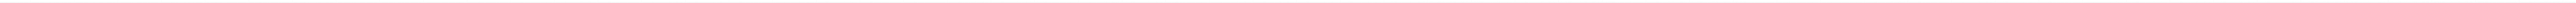

In [21]:
ds_nc_query[var_name].data.visualize()

Plotting the timeseries forces xarray to actually pull the data into memory, do the Fahrenheit conversion, and visualize, which takes 1-2 minutes.

In [22]:
%%time

ds_nc_query.hvplot()

/opt/conda/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 295.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 694 ms, sys: 862 ms, total: 1.56 s
Wall time: 2min 29s


:Curve   [time]   (T2M)

### Define Zarr chunking strategy <a class='anchor' name="4b"></a>[<font size=1>TOC</font>](#top)

While rechunking is not required for converting from NetCDF to Zarr, rechunking to better fit data access patterns can be a significant component of the benefit of moving to Zarr.  

There is no one-size-fits all optimal chunking strategy.  When selecting Zarr chunk sizes, consider:
- common read and write acess patterns (for example: time series queries)
- keeping the number of chunks/files created, and their size, to an appropriate amount for your storage characteristics
- making chunk sizes fit roughly into memory

Two points to keep in mind:
- for fast reads along a given dimension, you want to maximize the chunk size along that dimension (to minimize the number of chunks that need to be opened and read).
- when writing new data to a Zarr store, if the write touches any part of a chunk then the whole chunk will need to be rewritten.

If time series queries are a common access pattern but data will also need to be appended along the time dimension, you will need to achieve the right balance between large chunksizes (along the time dimension) which speed up reads, and small chunksizes which will make writes more efficient.

#### rechunker

The Python ```rechunker``` library allows you to  convert data chunks of one size, in one file format, to different-sized chunks in another format. 

Because ```rechunker``` uses an intermediate storage location when writing from the source to the target, it is designed to handle rechunking data sets too large to fit into memory. 

At this time, ```rechunker``` does not have an append function, which means if you want to add new data to an existing data set using ```rechunker``` you need to rechunk the entire new dataset, or use ```xarray.to_zarr()```.

First, let's change the chunksizes used in the original NetCDF files to make time series queries more efficient.

We'll make chunks longer in the time dimension to decrease the number of chunks that will be needed to be opened and read for a time series query. At the same time, let's make chunks smaller in the lat/lon dimensions to keep the overall size of each chunk (or object written on disk) and number of files at an appropriate level. 

We'll also use a chunk size smaller than the entire length of the time dimension (so that we will have more than one time chunk, and won't have to rewrite all chunks if we append along the time dimension later.

In [43]:
dims = ds_nc.dims.keys()
new_chunksizes = (1080, 90, 90)
new_chunksizes_dict = dict(zip(dims, new_chunksizes))

/opt/conda/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


### Set up Zarr store <a class='anchor' name="4c"></a>[<font size=1>TOC</font>](#top)

At this point, we define the location of the new Zarr store on Amazon S3. Rechunker needs a location defined for both the new Zarr store as well as a temporary, intermediate location for use when copying chunks from one set of files to the other.

In [45]:
zarr_store_url = f's3://{S3_BUCKET_ZARR}/converted/merra2_utc.zarr'
zarr_temp_url = f's3://{S3_BUCKET_ZARR}/converted/merra2_utc-tmp.zarr'

The URLs for the Zarr store need to be wrapped as filesystem objects (key-value pair).

In [46]:
#s3_priv = s3fs.S3FileSystem(anon=False, default_fill_cache=False)

import aiobotocore
profile_name = 'draios-dev-developer'
profile_session = aiobotocore.session.AioSession(profile=profile_name)
s3_priv = s3fs.S3FileSystem(anon=False, default_fill_cache=False, session=profile_session)

zarr_store = s3fs.S3Map(root=zarr_store_url, s3=s3_priv, check=False)
zarr_temp = s3fs.S3Map(root=zarr_temp_url, s3=s3_priv, check=False)

### Batch convert NetCDF to Zarr <a class='anchor' name="4d"></a>[<font size=1>TOC</font>](#top)

Now call the rechunk function, passing it the NetCDF dataset and desired chunk sizes for the T2M variable, and the location for the final and temporary Zarr stores on S3. This process should take roughly 5 minutes.

In [72]:
!aws s3 rm s3://{S3_BUCKET_ZARR}/converted/merra2_utc.zarr --recursive
!aws s3 rm s3://{S3_BUCKET_ZARR}/converted/merra2_utc-tmp.zarr --recursive

delete: s3://pculurc-zarr/converted/merra2_utc.zarr/.zattrs
delete: s3://pculurc-zarr/converted/merra2_utc.zarr/T2M/.zarray
delete: s3://pculurc-zarr/converted/merra2_utc.zarr/T2M/.zattrs
delete: s3://pculurc-zarr/converted/merra2_utc.zarr/lat/.zarray
delete: s3://pculurc-zarr/converted/merra2_utc.zarr/lat/.zattrs
delete: s3://pculurc-zarr/converted/merra2_utc.zarr/.zgroup
delete: s3://pculurc-zarr/converted/merra2_utc.zarr/lon/.zattrs
delete: s3://pculurc-zarr/converted/merra2_utc.zarr/lon/.zarray
delete: s3://pculurc-zarr/converted/merra2_utc.zarr/time/.zarray
delete: s3://pculurc-zarr/converted/merra2_utc.zarr/time/.zattrs
delete: s3://pculurc-zarr/converted/merra2_utc-tmp.zarr/.zgroup


In [73]:
%%time

ds_zarr = rechunk(
    ds_nc, 
    target_chunks={var_name: new_chunksizes_dict, 'time': None,'lat': None,'lon': None},
    max_mem='15GB',
    target_store = zarr_store, 
    temp_store = zarr_temp
)

CPU times: user 1.19 s, sys: 77 ms, total: 1.27 s
Wall time: 3.53 s


In [76]:
ds_zarr.execute()

2023-12-20 11:12:29,367 - distributed.protocol.pickle - ERROR - Failed to serialize <ToPickle: HighLevelGraph with 14 layers.
 0. config-af5fb75a5bada11fa7d696c0cb66d2b8
 1. copy_read_to_write-af5fb75a5bada11fa7d696c0cb66d2b8
 2. copy_read_to_write-checkpoint-af5fb75a5bada11fa7d696c0cb66d2b8
 3. config-428d7450cc41495e9f26697712ccce68
 4. copy_read_to_write-428d7450cc41495e9f26697712ccce68
 5. copy_read_to_write-checkpoint-428d7450cc41495e9f26697712ccce68
 6. config-7f70d498690c60b5bd85f8912ad79123
 7. copy_read_to_write-7f70d498690c60b5bd85f8912ad79123
 8. copy_read_to_write-checkpoint-7f70d498690c60b5bd85f8912ad79123
 9. config-ce292f4df8a52ef385187e444984778e
 10. copy_read_to_intermediate-ce292f4df8a52ef385187e444984778e
 11. copy_read_to_intermediate-checkpoint-ce292f4df8a52ef385187e444984778e
 12. copy_intermediate_to_write-ce292f4df8a52ef385187e444984778e
 13. copy_intermediate_to_write-checkpoint-ce292f4df8a52ef385187e444984778e
>.
Traceback (most recent call last):
  File "/op

TypeError: ('Could not serialize object of type HighLevelGraph', '<ToPickle: HighLevelGraph with 14 layers.\n<dask.highlevelgraph.HighLevelGraph object at 0x7f09bcfbc940>\n 0. config-af5fb75a5bada11fa7d696c0cb66d2b8\n 1. copy_read_to_write-af5fb75a5bada11fa7d696c0cb66d2b8\n 2. copy_read_to_write-checkpoint-af5fb75a5bada11fa7d696c0cb66d2b8\n 3. config-428d7450cc41495e9f26697712ccce68\n 4. copy_read_to_write-428d7450cc41495e9f26697712ccce68\n 5. copy_read_to_write-checkpoint-428d7450cc41495e9f26697712ccce68\n 6. config-7f70d498690c60b5bd85f8912ad79123\n 7. copy_read_to_write-7f70d498690c60b5bd85f8912ad79123\n 8. copy_read_to_write-checkpoint-7f70d498690c60b5bd85f8912ad79123\n 9. config-ce292f4df8a52ef385187e444984778e\n 10. copy_read_to_intermediate-ce292f4df8a52ef385187e444984778e\n 11. copy_read_to_intermediate-checkpoint-ce292f4df8a52ef385187e444984778e\n 12. copy_intermediate_to_write-ce292f4df8a52ef385187e444984778e\n 13. copy_intermediate_to_write-checkpoint-ce292f4df8a52ef385187e444984778e\n>')

The cell below shows the directory structure of the Zarr store that is created. The root of a Zarr store is a Zarr group. Each NetCDF dimension (lat, lon, time) and data variable (T2M) is stored in its own subfolder, as a Zarr array. 

All Zarr metadata is stored as plain text JSON. The .zattr file contains metadata supplied by the user, and .zgroup holds metadata for the group. 

In [ ]:
!aws s3 ls {zarr_store_url}/

Inside the T2M subfolder are two more metadata files -- .zarray and .zattr -- along with the and binary chunks (or files) that hold the actual data. Chunk names have three components, one for each dimension. 

In [ ]:
!aws s3 ls {zarr_store_url}/T2M/ --human-readable --summarize

The T2M/.zarray file holds the metadata for the T2M Dask array, which includes data type, compression type, chunking strategy, and original shape.

In [ ]:
import json
with s3_priv.open(f'{zarr_store_url}/T2M/.zarray', 'rb') as f:
    print(json.dumps(json.loads(f.read()), indent=2))

Zarr allows you to easily consolidate metadata for the entire Zarr store into a single .zmetadata file, saved at the root of the Zarr directory. 

In [ ]:
zarr.consolidate_metadata(zarr_store_url)

In [ ]:
!aws s3 ls {zarr_store_url}/

### Query the Zarr store <a class='anchor' name="4e"></a>[<font size=1>TOC</font>](#top)

We can query the new Zarr store using xarray.

In [ ]:
%%time

ds_zarr = xr.open_zarr(store=zarr_store_url, chunks={}, consolidated=True)

It contains the single T2M variable we converted, chunked as specified.

In [ ]:
ds_zarr

In [ ]:
ds_zarr[var_name].chunksizes

Querying from Zarr for the time series data and plotting it now takes seconds instead of minutes (from NetCDF).

In [ ]:
%%time

ds_zarr_query = ds_zarr.sel(lat=40.7, lon=74, method='nearest')
ds_zarr_query = (9/5) * (ds_zarr_query - 273.15) + 32

In [ ]:
%%time

ds_zarr_query.hvplot()

## Append NetCDF Files to Zarr using xarray <a class='anchor' name="5"></a>[<font size=1>TOC</font>](#top)

***

The rechunker library does not have a way to append data to an existing Zarr store.  For that, ```xarray.to_zarr``` is an option for appending data along a dimension, such as time. Let's append one week of additional data to the Zarr store, one day at a time.

In [ ]:
start = '20210301'
end = '20210307'

nc_files = ['s3://power-datastore/v9/hourly/{}/{}/power_901_hourly_{}_merra2_utc.nc'.format(
                d.strftime('%Y'), 
                d.strftime('%m'),
                d.strftime('%Y%m%d')) for d in make_day_range(start, end)]
nc_files

Appending 7 days of data, one day at a time, takes roughly 10 minutes.  When appending to a Zarr store, if data needs to be added to a chunk (such as additional observations along the time dimension), the entire chunk will need to be rewritten.

In [ ]:
%%time

for file in nc_files:    
    print(f'Appending {file}')
    
    # open a single file as a dataset
    ds_nc_append = xr.open_dataset(s3.open(file), engine='h5netcdf', chunks={})    
    # pull out T2M
    ds_nc_append = ds_nc_append[[var_name]]
    # rechunk in memory
    ds_nc_append = ds_nc_append.chunk(chunks = new_chunksizes_dict)
    # append
    ds_nc_append.to_zarr(zarr_store_url, mode="a", append_dim='time', consolidated=True)

We can now reopen the file to see the additional observations along the time dimension.

In [ ]:
%%time

ds_zarr = xr.open_zarr(store=zarr_store_url, chunks={}, consolidated=True)

The Zarr store now contain the additional days of data. All chunks that include data for the new time observations have been rewritten on S3.

In [ ]:
ds_zarr

The chunksizes show that the number of observations in the second (last) chunk in the time dimension is now larger, compared to before the data was appended.

In [ ]:
ds_zarr[var_name].chunksizes

Querying from Zarr for the time series data and plotting it takes seconds instead of minutes (from NetCDF).

In [ ]:
%%time
ds_zarr_query = ds_zarr.sel(lat=40.7, lon=74, method='nearest')
ds_zarr_query = (9/5) * (ds_zarr_query - 273.15) + 32

In [ ]:
%%time

ds_zarr_query.hvplot()

## Scale in Dask cluster <a class='anchor' name="7"></a>[<font size=1>TOC</font>](#top)

***

In [ ]:
NUM_DASK_WORKERS = 1

DASK_CLUSTER_NAME = "Dask-Cluster"
DASK_CLUSTER_SERVICE = "Dask-Worker"

!aws ecs update-service --service {DASK_CLUSTER_SERVICE} --desired-count {NUM_DASK_WORKERS} --cluster {DASK_CLUSTER_NAME}